# AMS 559 Assignment 2
Pratik Mukund Velhal </br>
112675099

In [0]:
#This project has been done on Google colab
#data mounted from google drive. You can change path to local files to run it locally
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#Imports
import pandas as pd
import numpy as np
from cvxpy import *
import cvxpy
import matplotlib.pyplot as plt
import math

# Loading Data

In [0]:
#Load all data into dataframes
#Please change filepath to your own file path while running
filepath = "/content/drive/My Drive"
homebpowerdata=pd.read_csv(filepath + "/data/Home B - 2014/HomeB-meter1_2014.csv")
homecpowerdata=pd.read_csv(filepath + "/data/Home C -2015/HomeC-meter1_2015.csv")
homefpowerdata=pd.read_csv(filepath + "/data/Home F - 2016/HomeF-meter3_2016.csv")

homeblrpred=pd.read_csv(filepath + "/data/b_pred_lr.csv")
homebrfpred=pd.read_csv(filepath + "/data/b_pred_rf.csv")
homeclrpred=pd.read_csv(filepath + "/data/c_pred_lr.csv")
homecrfpred=pd.read_csv(filepath + "/data/c_pred_rf.csv")
homeflrpred=pd.read_csv(filepath + "/data/f_pred_lr.csv")
homefrfpred=pd.read_csv(filepath + "/data/f_pred_rf.csv")

homebpowerdf = pd.DataFrame(homebpowerdata)
homecpowerdf = pd.DataFrame(homecpowerdata)
homefpowerdf = pd.DataFrame(homefpowerdata)

homeblrpreddf = pd.DataFrame(homeblrpred)
homebrfpreddf = pd.DataFrame(homebrfpred)
homeclrpreddf = pd.DataFrame(homeclrpred)
homecrfpreddf = pd.DataFrame(homecrfpred)
homeflrpreddf = pd.DataFrame(homeflrpred)
homefrfpreddf = pd.DataFrame(homefrfpred)

#Convert Date column to a datetime object
homebpowerdf['Date & Time']= pd.to_datetime(homebpowerdf['Date & Time']) 
homecpowerdf['Date & Time']= pd.to_datetime(homecpowerdf['Date & Time']) 
homefpowerdf['Date & Time']= pd.to_datetime(homefpowerdf['Date & Time']) 

homebpowerdf["Date & Time"]= homebpowerdf["Date & Time"].dt.floor(freq="30T")
homebpowerdf= homebpowerdf.groupby("Date & Time").sum().reset_index()

homecpowerdf["Date & Time"]= homecpowerdf["Date & Time"].dt.floor(freq="30T")
homecpowerdf= homecpowerdf.groupby("Date & Time").sum().reset_index()

homefpowerdf["Date & Time"]= homefpowerdf["Date & Time"].dt.floor(freq="30T")
homefpowerdf= homefpowerdf.groupby("Date & Time").sum().reset_index()


In [0]:
start_date = '11-01-2014'
end_date = '11-15-2014'
mask = (homebpowerdf["Date & Time"] >= start_date) & (homebpowerdf["Date & Time"] < end_date)
homebpowerdf = homebpowerdf.loc[mask]
homebpowerdf.reset_index(drop=True, inplace=True)

start_date = '11-01-2015'
end_date = '11-15-2015'
mask = (homecpowerdf["Date & Time"] >= start_date) & (homecpowerdf["Date & Time"] < end_date)
homecpowerdf = homecpowerdf.loc[mask]
homecpowerdf.reset_index(drop=True, inplace=True)

start_date = '11-01-2016'
end_date = '11-15-2016'
mask = (homefpowerdf["Date & Time"] >= start_date) & (homefpowerdf["Date & Time"] < end_date)
homefpowerdf = homefpowerdf.loc[mask]
homefpowerdf.reset_index(drop=True, inplace=True)

In [0]:
price = 0.2 # 0.4$/kwH -> 0.4/2 $ / kW 30 min -> 0.2$
a=2 #4$/kwH -> 2$/kw 30 min
b=2 #4$/kwH -> 2$/kw 30 min

def FindCost(y,x,price,a,b):
  res = 0
  for t in range(1,len(y)):
    res += (price*x[t] + a*np.maximum(0,y[t]-x[t]) + b*np.absolute(x[t]-x[t-1]))
  return res

def MakePlot(provision,df,param,i,j,title=None):
  provisiondf = pd.DataFrame(data=provision, columns=["Provision"])
  df.plot(y=param,use_index=True,ax=axes[i,j]) 
  provisiondf.plot(y="Provision",use_index=True, ax=axes[i,j], ls="-",color='red' )
  if(title!=None):
    axes[i,j].set_title(title, fontsize=12)
  axes[i,j].set_xlabel("Time (t)")
  axes[i,j].set_ylabel("Energy (KW)")
  #plt.legend(loc="upper left")
  #plt.show()

# Offline Static Optimization

Optimal Offline Static Cost for House B: 193.02462686933774
Optimal Offline Static Cost for House C: 257.28038579942967
Optimal Offline Static Cost for House F: 19154.15893700204


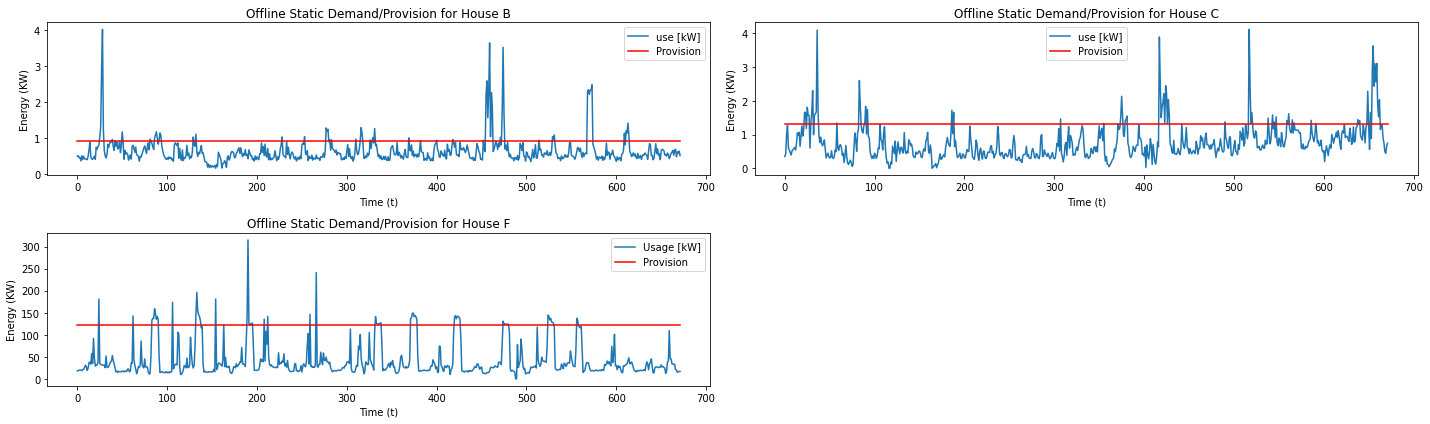

In [0]:
offline_static_cost_b=float("inf")
offline_static_cost_c=float("inf")
offline_static_cost_f=float("inf")
#Offline Static
#switching cost (b) is 0 for static offline
def GetOfflineStaticCost(price,a,demandarr):
  provisionvar = cvxpy.Variable()
  localcost = 0
  for t in range(len(demandarr)):
    localcost += (price*provisionvar + a*cvxpy.maximum(0,demandarr[t]-provisionvar))
  obj = cvxpy.Minimize(localcost)
  prob = cvxpy.Problem(obj)
  res = prob.solve()
  return res,provisionvar.value

fig = plt.figure(figsize=(20,6))
axes = fig.subplots(nrows=2, ncols=2)

demandarr = np.asarray(homebpowerdf['use [kW]'])
cost,provision = GetOfflineStaticCost(price,a,demandarr)
#print("Optimal House B provision:",provision)
if(cost<offline_static_cost_b):
  offline_static_cost_b = cost
print("Optimal Offline Static Cost for House B:",cost)
provisionarr = np.full(672, provision)
MakePlot(provisionarr,homebpowerdf,'use [kW]',0,0,"Offline Static Demand/Provision for House B")

demandarr = np.asarray(homecpowerdf['use [kW]'])
cost,provision = GetOfflineStaticCost(price,a,demandarr)
#print("Optimal House C provision:",provision)
if(cost<offline_static_cost_c):
  offline_static_cost_c = cost
print("Optimal Offline Static Cost for House C:",cost)
provisionarr = np.full(672, provision)
MakePlot(provisionarr,homecpowerdf,'use [kW]',0,1,"Offline Static Demand/Provision for House C")

demandarr = np.asarray(homefpowerdf['Usage [kW]'])
cost,provision = GetOfflineStaticCost(price,a,demandarr)
#print("Optimal House F provision:",provision)
if(cost<offline_static_cost_f):
  offline_static_cost_f = cost
print("Optimal Offline Static Cost for House F:",cost)
provisionarr = np.full(672, provision)
MakePlot(provisionarr,homefpowerdf,'Usage [kW]',1,0,"Offline Static Demand/Provision for House F")

plt.tight_layout()
fig.delaxes(axes[1][1])

# Offline Dynamic Optimization

Optimal Offline Dynamic Cost for House B: 160.4711960089692
Optimal Offline Dynamic Cost for House C: 209.79963463572142
Optimal Offline Dynamic Cost for House F: 14744.553657558057


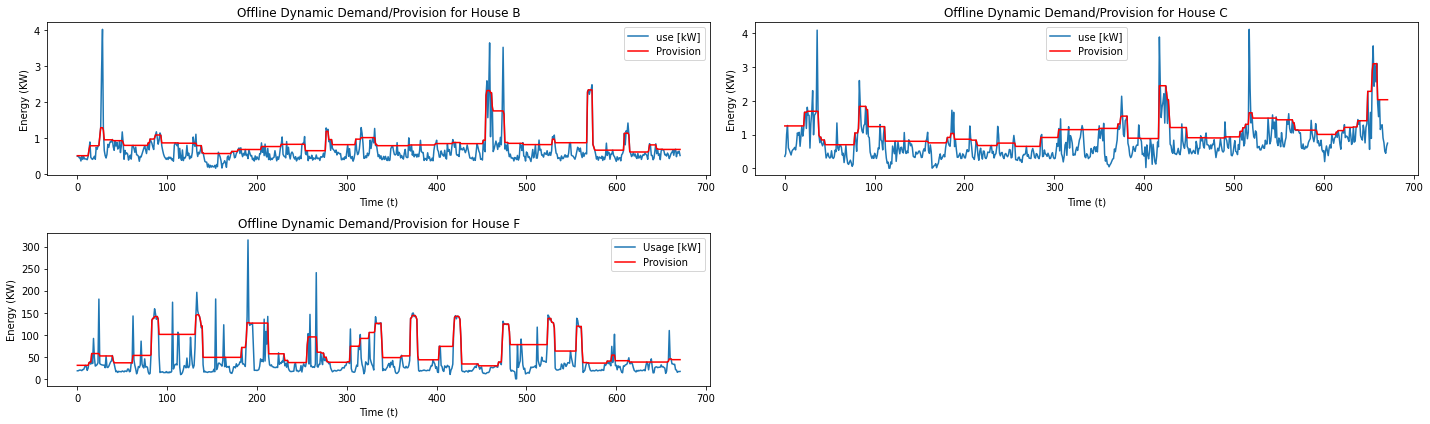

In [0]:
offline_dynamic_cost_b=float("inf")
offline_dynamic_cost_c=float("inf")
offline_dynamic_cost_f=float("inf")

#Offline Dynamic
def GetOfflineDynamicCost(a,b,demandarr,price):
  x = cvxpy.Variable(len(demandarr))
  arraylen =len(demandarr)
  localcost=price*x[0] 
  for t in range(1,arraylen):
    localcost += (price*x[t] + a*cvxpy.maximum(0,demandarr[t]-x[t]) + b*abs(x[t]-x[t-1]))
  obj = cvxpy.Minimize(localcost)
  prob = cvxpy.Problem(obj)
  res = prob.solve()
  return res,x.value

fig = plt.figure(figsize=(20,6))
axes = fig.subplots(nrows=2, ncols=2)

demandarr = np.asarray(homebpowerdf['use [kW]'])
cost,provision = GetOfflineDynamicCost(a,b,demandarr,price)
if(cost<offline_dynamic_cost_b):
  offline_dynamic_cost_b = cost
print("Optimal Offline Dynamic Cost for House B:",cost)
MakePlot(provision,homebpowerdf,'use [kW]',0,0,"Offline Dynamic Demand/Provision for House B")

demandarr = np.asarray(homecpowerdf['use [kW]'])
cost,provision = GetOfflineDynamicCost(a,b,demandarr,price)
if(cost<offline_dynamic_cost_c):
  offline_dynamic_cost_c = cost
print("Optimal Offline Dynamic Cost for House C:",cost)
MakePlot(provision,homecpowerdf,'use [kW]',0,1,"Offline Dynamic Demand/Provision for House C")

demandarr = np.asarray(homefpowerdf['Usage [kW]'])
cost,provision = GetOfflineDynamicCost(a,b,demandarr,price)
if(cost<offline_dynamic_cost_f):
  offline_dynamic_cost_f = cost
print("Optimal Offline Dynamic Cost for House F:",cost)
MakePlot(provision,homefpowerdf,'Usage [kW]',1,0,"Offline Dynamic Demand/Provision for House F")

plt.tight_layout()
fig.delaxes(axes[1][1])

# Online Gradient Descent

Optimal Cost of House B for step size = 1/root(t) using OGD :  409.48640060211403
Optimal Cost of House B for step size = 1/t using OGD :  223.68881880112093
Optimal Cost of House B for step size = 0.01 using OGD :  241.39831334200022
Optimal Cost of House B for step size = 0.05 using OGD :  335.0710855639998
Optimal Cost of House B for step size = 0.1 using OGD :  480.25609890200093
Optimal Cost of House B for step size = 0.2 using OGD :  782.3768311200017


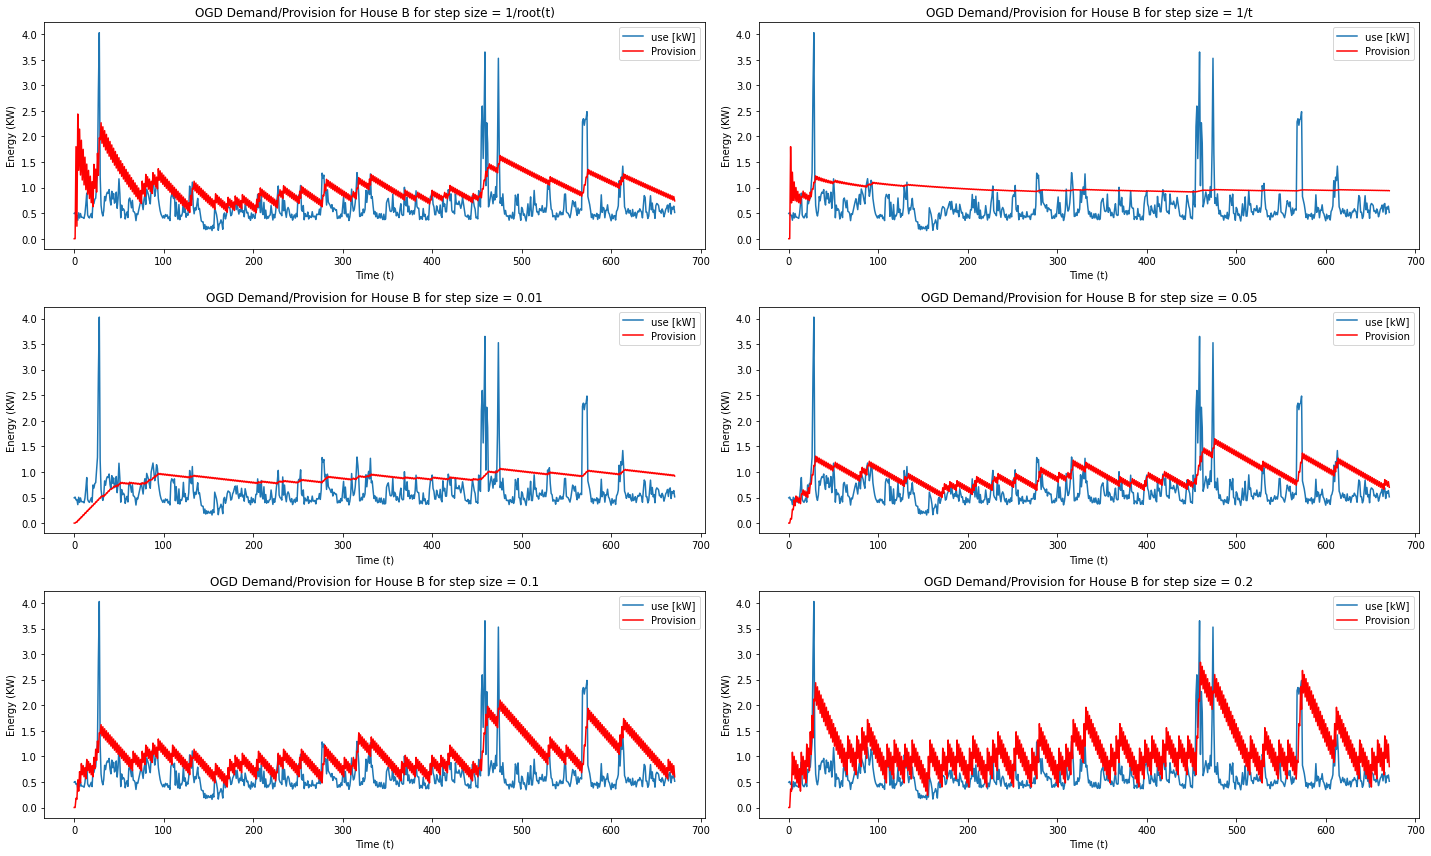

In [0]:
ogd_cost_b=float("inf")
ogd_cost_c=float("inf")
ogd_cost_f=float("inf")
ogdcostarr = []

def derivative(t,x,y,p):
  res = p
  if y[t] > x[t]:
    res = res-a
  if x[t] < x[t-1]:
    res=res-b
  elif x[t] > x[t-1]:
    res=res+b  
  return res

def OnlineGradientDescent(y,step,price,a,b):
    x = [0]*len(y)
    for t in range(1,len(y)-1):
        stepsize= step[t-1]
        gradient =derivative(t,x,y,price)
        x[t+1] = x[t] - stepsize*(gradient)
    return x

fig = plt.figure(figsize=(20,12))
axes = fig.subplots(nrows=3, ncols=2)

demandarr = np.asarray(homebpowerdf['use [kW]'])
#step size = 1/root(t)
stepsize = []
for i in range (1,len(demandarr)):
  stepsize.append(1/np.sqrt(i))
x = OnlineGradientDescent(demandarr,stepsize,price,a,b)
cost = FindCost(demandarr,x,price,a,b)
if(cost<ogd_cost_b):
  ogd_cost_b = cost
ogdcostarr.append(cost)
print("Optimal Cost of House B for step size = 1/root(t) using OGD : ",cost)
MakePlot(x,homebpowerdf,'use [kW]',0,0,"OGD Demand/Provision for House B for step size = 1/root(t)")

#step size = 1/t
stepsize = []
for i in range (1,len(demandarr)):
  stepsize.append(1/i)
x = OnlineGradientDescent(demandarr,stepsize,price,a,b)
cost = FindCost(demandarr,x,price,a,b)
if(cost<ogd_cost_b):
  ogd_cost_b = cost
ogdcostarr.append(cost)
print("Optimal Cost of House B for step size = 1/t using OGD : ",cost)
MakePlot(x,homebpowerdf,'use [kW]',0,1,"OGD Demand/Provision for House B for step size = 1/t")

#step size = 0.01
stepsize = []
for i in range (1,len(demandarr)):
  stepsize.append(0.01)
x = OnlineGradientDescent(demandarr,stepsize,price,a,b)
cost = FindCost(demandarr,x,price,a,b)
if(cost<ogd_cost_b):
  ogd_cost_b = cost
ogdcostarr.append(cost)
print("Optimal Cost of House B for step size = 0.01 using OGD : ",cost)
MakePlot(x,homebpowerdf,'use [kW]',1,0,"OGD Demand/Provision for House B for step size = 0.01")

#step size = 0.05
stepsize = []
for i in range (1,len(demandarr)):
  stepsize.append(0.05)
x = OnlineGradientDescent(demandarr,stepsize,price,a,b)
cost = FindCost(demandarr,x,price,a,b)
if(cost<ogd_cost_b):
  ogd_cost_b = cost
ogdcostarr.append(cost)
print("Optimal Cost of House B for step size = 0.05 using OGD : ",cost)
MakePlot(x,homebpowerdf,'use [kW]',1,1,"OGD Demand/Provision for House B for step size = 0.05")

#step size = 0.1
stepsize = []
for i in range (1,len(demandarr)):
  stepsize.append(0.1)
x = OnlineGradientDescent(demandarr,stepsize,price,a,b)
cost = FindCost(demandarr,x,price,a,b)
if(cost<ogd_cost_b):
  ogd_cost_b = cost
ogdcostarr.append(cost)
print("Optimal Cost of House B for step size = 0.1 using OGD : ",cost)
MakePlot(x,homebpowerdf,'use [kW]',2,0,"OGD Demand/Provision for House B for step size = 0.1")

#step size = 0.2
stepsize = []
for i in range (1,len(demandarr)):
  stepsize.append(0.2)
x = OnlineGradientDescent(demandarr,stepsize,price,a,b)
cost = FindCost(demandarr,x,price,a,b)
if(cost<ogd_cost_b):
  ogd_cost_b = cost
ogdcostarr.append(cost)
print("Optimal Cost of House B for step size = 0.2 using OGD : ",cost)
MakePlot(x,homebpowerdf,'use [kW]',2,1,"OGD Demand/Provision for House B for step size = 0.2")

plt.tight_layout()

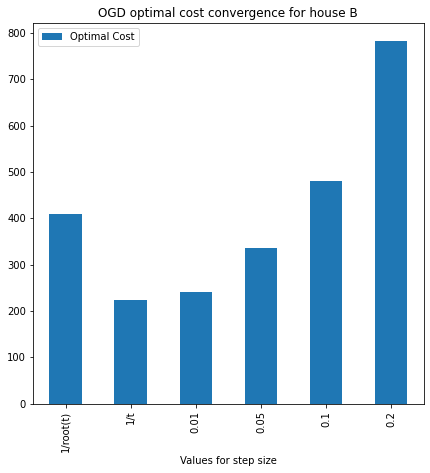

In [0]:
stepsizearr=["1/root(t)","1/t","0.01","0.05","0.1","0.2"]
ogddf = pd.DataFrame({
  'Values for step size': stepsizearr,
  'Optimal Cost': ogdcostarr,
})
ogddf.plot.bar(x='Values for step size', y='Optimal Cost',figsize=(7,7),title="OGD optimal cost convergence for house B")

Optimal Cost of House C for step size = 1/root(t) using OGD :  455.33546520695234
Optimal Cost of House C for step size = 1/t using OGD :  293.98664055605184
Optimal Cost of House C for step size = 0.01 using OGD :  326.1333433380002
Optimal Cost of House C for step size = 0.05 using OGD :  388.7217311080004
Optimal Cost of House C for step size = 0.1 using OGD :  519.7610377760009
Optimal Cost of House C for step size = 0.2 using OGD :  819.0762633320014


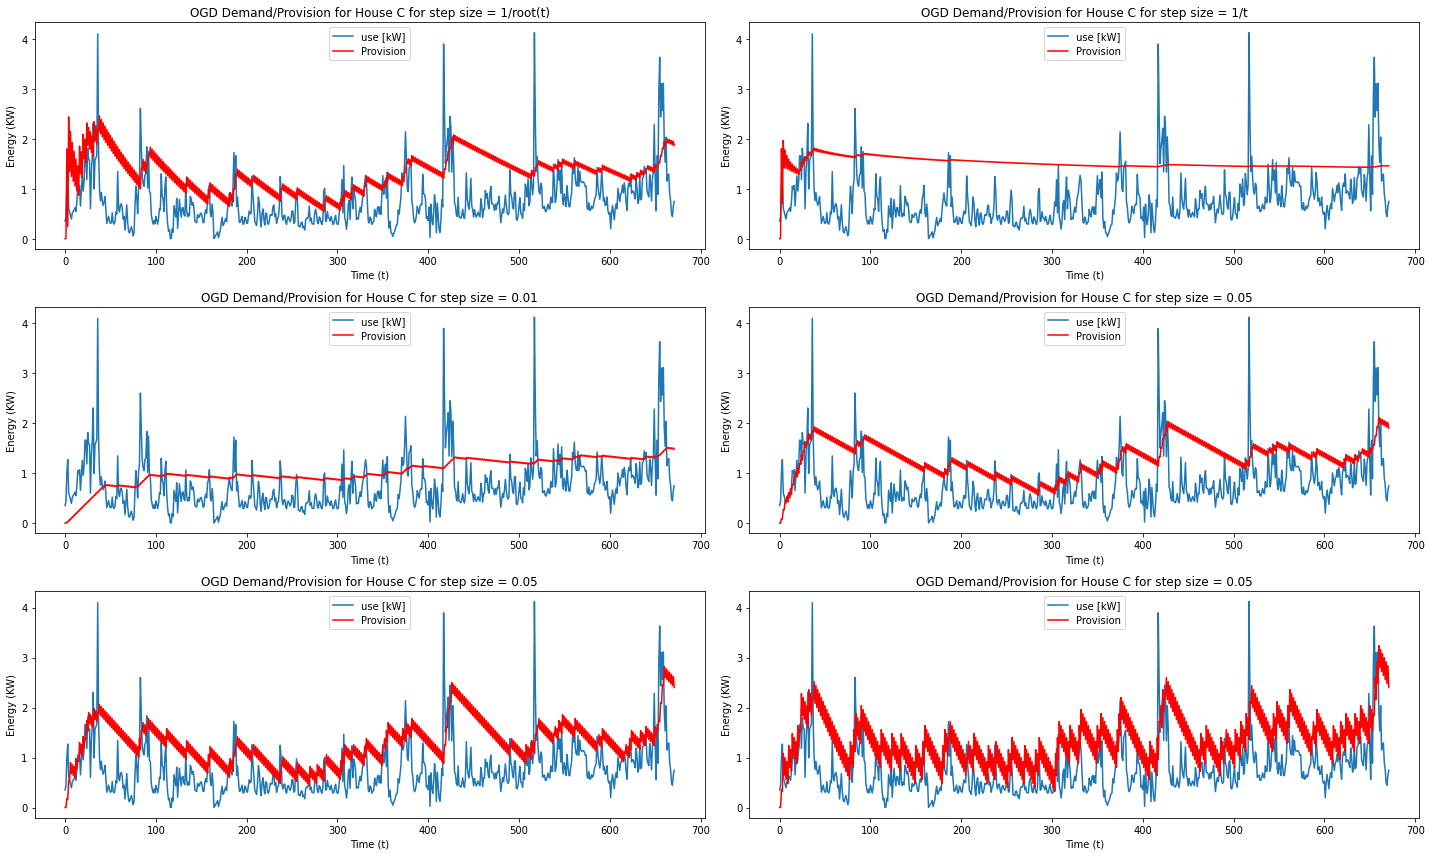

In [0]:
fig = plt.figure(figsize=(20,12))
axes = fig.subplots(nrows=3, ncols=2)
ogdcostarr=[]
demandarr = np.asarray(homecpowerdf['use [kW]'])
#step size = 1/root(t)
stepsize = []
for i in range (1,len(demandarr)):
  stepsize.append(1/np.sqrt(i))
x = OnlineGradientDescent(demandarr,stepsize,price,a,b)
cost = FindCost(demandarr,x,price,a,b)
if(cost<ogd_cost_c):
  ogd_cost_c = cost
ogdcostarr.append(cost)
print("Optimal Cost of House C for step size = 1/root(t) using OGD : ",cost)
MakePlot(x,homecpowerdf,'use [kW]',0,0,"OGD Demand/Provision for House C for step size = 1/root(t)")

#step size = 1/t
stepsize = []
for i in range (1,len(demandarr)):
  stepsize.append(1/i)
x = OnlineGradientDescent(demandarr,stepsize,price,a,b)
cost = FindCost(demandarr,x,price,a,b)
if(cost<ogd_cost_c):
  ogd_cost_c = cost
ogdcostarr.append(cost)
print("Optimal Cost of House C for step size = 1/t using OGD : ",cost)
MakePlot(x,homecpowerdf,'use [kW]',0,1,"OGD Demand/Provision for House C for step size = 1/t")

#step size = 0.01
stepsize = []
for i in range (1,len(demandarr)):
  stepsize.append(0.01)
x = OnlineGradientDescent(demandarr,stepsize,price,a,b)
cost = FindCost(demandarr,x,price,a,b)
if(cost<ogd_cost_c):
  ogd_cost_c = cost
ogdcostarr.append(cost)
print("Optimal Cost of House C for step size = 0.01 using OGD : ",cost)
MakePlot(x,homecpowerdf,'use [kW]',1,0,"OGD Demand/Provision for House C for step size = 0.01")

#step size = 0.05
stepsize = []
for i in range (1,len(demandarr)):
  stepsize.append(0.05)
x = OnlineGradientDescent(demandarr,stepsize,price,a,b)
cost = FindCost(demandarr,x,price,a,b)
if(cost<ogd_cost_c):
  ogd_cost_c = cost
ogdcostarr.append(cost)
print("Optimal Cost of House C for step size = 0.05 using OGD : ",cost)
MakePlot(x,homecpowerdf,'use [kW]',1,1,"OGD Demand/Provision for House C for step size = 0.05")

#step size = 0.1
stepsize = []
for i in range (1,len(demandarr)):
  stepsize.append(0.1)
x = OnlineGradientDescent(demandarr,stepsize,price,a,b)
cost = FindCost(demandarr,x,price,a,b)
if(cost<ogd_cost_c):
  ogd_cost_c = cost
ogdcostarr.append(cost)
print("Optimal Cost of House C for step size = 0.1 using OGD : ",cost)
MakePlot(x,homecpowerdf,'use [kW]',2,0,"OGD Demand/Provision for House C for step size = 0.05")

#step size = 0.2
stepsize = []
for i in range (1,len(demandarr)):
  stepsize.append(0.2)
x = OnlineGradientDescent(demandarr,stepsize,price,a,b)
cost = FindCost(demandarr,x,price,a,b)
if(cost<ogd_cost_c):
  ogd_cost_c = cost
ogdcostarr.append(cost)
print("Optimal Cost of House C for step size = 0.2 using OGD : ",cost)
MakePlot(x,homecpowerdf,'use [kW]',2,1,"OGD Demand/Provision for House C for step size = 0.05")

plt.tight_layout()

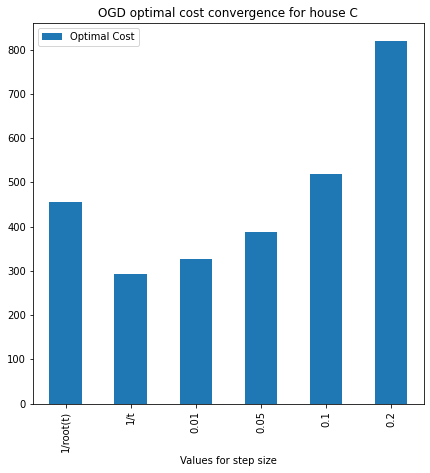

In [0]:
stepsizearr=["1/root(t)","1/t","0.01","0.05","0.1","0.2"]
ogddf = pd.DataFrame({
  'Values for step size': stepsizearr,
  'Optimal Cost': ogdcostarr,
})
ogddf.plot.bar(x='Values for step size', y='Optimal Cost',figsize=(7,7),title="OGD optimal cost convergence for house C")

Optimal Cost of House F for step size = 1/t using OGD :  44782.38707788378
Optimal Cost of House F for step size = 1/root(t) using OGD :  27506.09210252876
Optimal Cost of House F for step size = 1 using OGD :  23832.682333368033
Optimal Cost of House F for step size = 5 using OGD :  31830.718733350004


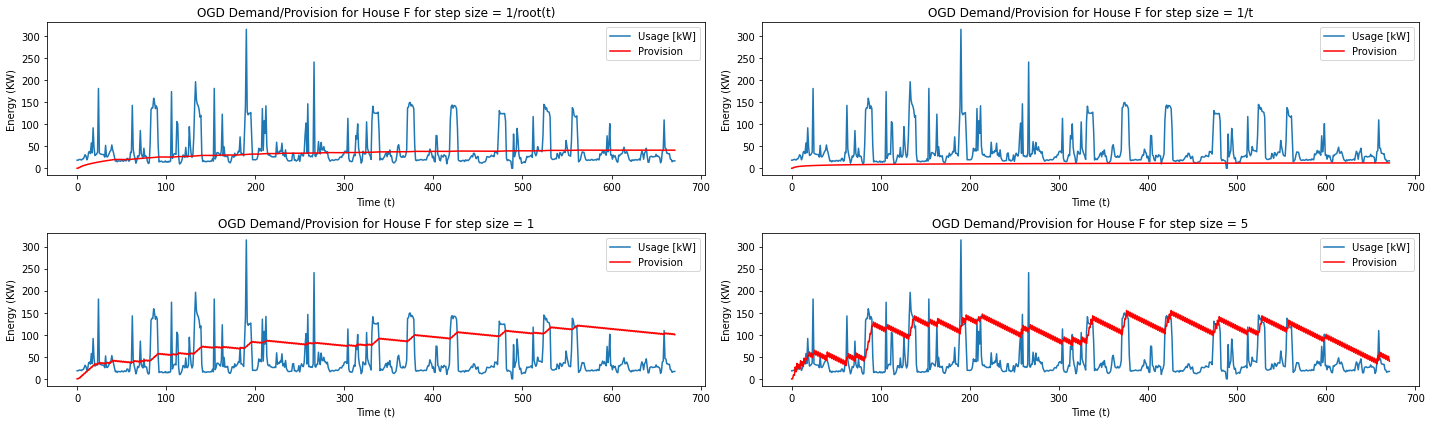

In [0]:
fig = plt.figure(figsize=(20,6))
axes = fig.subplots(nrows=2, ncols=2)
ogdcostarr=[]
demandarr = np.asarray(homefpowerdf['Usage [kW]'])

#step size = 1/t
stepsize = []
for i in range (1,len(demandarr)):
  stepsize.append(1/i)
x = OnlineGradientDescent(demandarr,stepsize,price,a,b)
cost = FindCost(demandarr,x,price,a,b)
if(cost<ogd_cost_f):
  ogd_cost_f = cost
ogdcostarr.append(cost)
print("Optimal Cost of House F for step size = 1/t using OGD : ",cost)
MakePlot(x,homefpowerdf,'Usage [kW]',0,1,"OGD Demand/Provision for House F for step size = 1/t")

#step size = 1/root(t)
stepsize = []
for i in range (1,len(demandarr)):
  stepsize.append(1/np.sqrt(i))
x = OnlineGradientDescent(demandarr,stepsize,price,a,b)
cost = FindCost(demandarr,x,price,a,b)
if(cost<ogd_cost_f):
  ogd_cost_f = cost
ogdcostarr.append(cost)
print("Optimal Cost of House F for step size = 1/root(t) using OGD : ",cost)
MakePlot(x,homefpowerdf,'Usage [kW]',0,0,"OGD Demand/Provision for House F for step size = 1/root(t)")

#step size = 1
stepsize = []
for i in range (1,len(demandarr)):
  stepsize.append(1)
x = OnlineGradientDescent(demandarr,stepsize,price,a,b)
cost = FindCost(demandarr,x,price,a,b)
if(cost<ogd_cost_f):
  ogd_cost_f = cost
ogdcostarr.append(cost)
print("Optimal Cost of House F for step size = 1 using OGD : ",cost)
MakePlot(x,homefpowerdf,'Usage [kW]',1,0,"OGD Demand/Provision for House F for step size = 1")

#step size = 5
stepsize = []
for i in range (1,len(demandarr)):
  stepsize.append(5)
x = OnlineGradientDescent(demandarr,stepsize,price,a,b)
cost = FindCost(demandarr,x,price,a,b)
if(cost<ogd_cost_f):
  ogd_cost_f = cost
ogdcostarr.append(cost)
print("Optimal Cost of House F for step size = 5 using OGD : ",cost)
MakePlot(x,homefpowerdf,'Usage [kW]',1,1,"OGD Demand/Provision for House F for step size = 5")

plt.tight_layout()

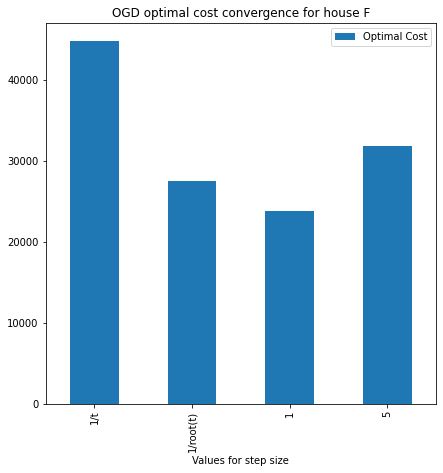

In [0]:
stepsizearr=["1/t","1/root(t)","1","5"]
ogddf = pd.DataFrame({
  'Values for step size': stepsizearr,
  'Optimal Cost': ogdcostarr,
})
ogddf.plot.bar(x='Values for step size', y='Optimal Cost',figsize=(7,7),title="OGD optimal cost convergence for house F")

# Receding Horizon Control

In [0]:
def GetRHC(a,b,y_pred,window,price):
  x_optimal = [0]*672
  for t in range(1,672):
    if(t>=len(y_pred)):
      break
    localcost = 0
    y_window = y_pred[t:t+window]
    x_window = cvxpy.Variable(window)
    for i in range(len(y_window)):
      localcost += (price*x_window[i] + a*cvxpy.maximum(0,y_window[i]-x_window[i]) + b*abs(x_window[i]-x_window[i-1]))   
    constraints = [x_window >= 0]  
    obj = cvxpy.Minimize(localcost)
    prob = cvxpy.Problem(obj, constraints)
    prob.solve()
    x_optimal[t] = x_window.value[0]
  return x_optimal

Optimal Cost of House B for window size =  5  using RHC and Linear Regression predictions:  244.24407087637803
Optimal Cost of House B for window size =  10  using RHC and Linear Regression predictions:  231.20159288973147
Optimal Cost of House B for window size =  15  using RHC and Linear Regression predictions:  228.66815943200973
Optimal Cost of House B for window size =  30  using RHC and Linear Regression predictions:  226.03379352797668
Optimal Cost of House B for window size =  5  using RHC and Random Forest predictions:  247.68722421050907
Optimal Cost of House B for window size =  10  using RHC and Random Forest predictions:  235.0044714748754
Optimal Cost of House B for window size =  15  using RHC and Random Forest predictions:  236.02810225245432
Optimal Cost of House B for window size =  30  using RHC and Random Forest predictions:  229.92313484873102


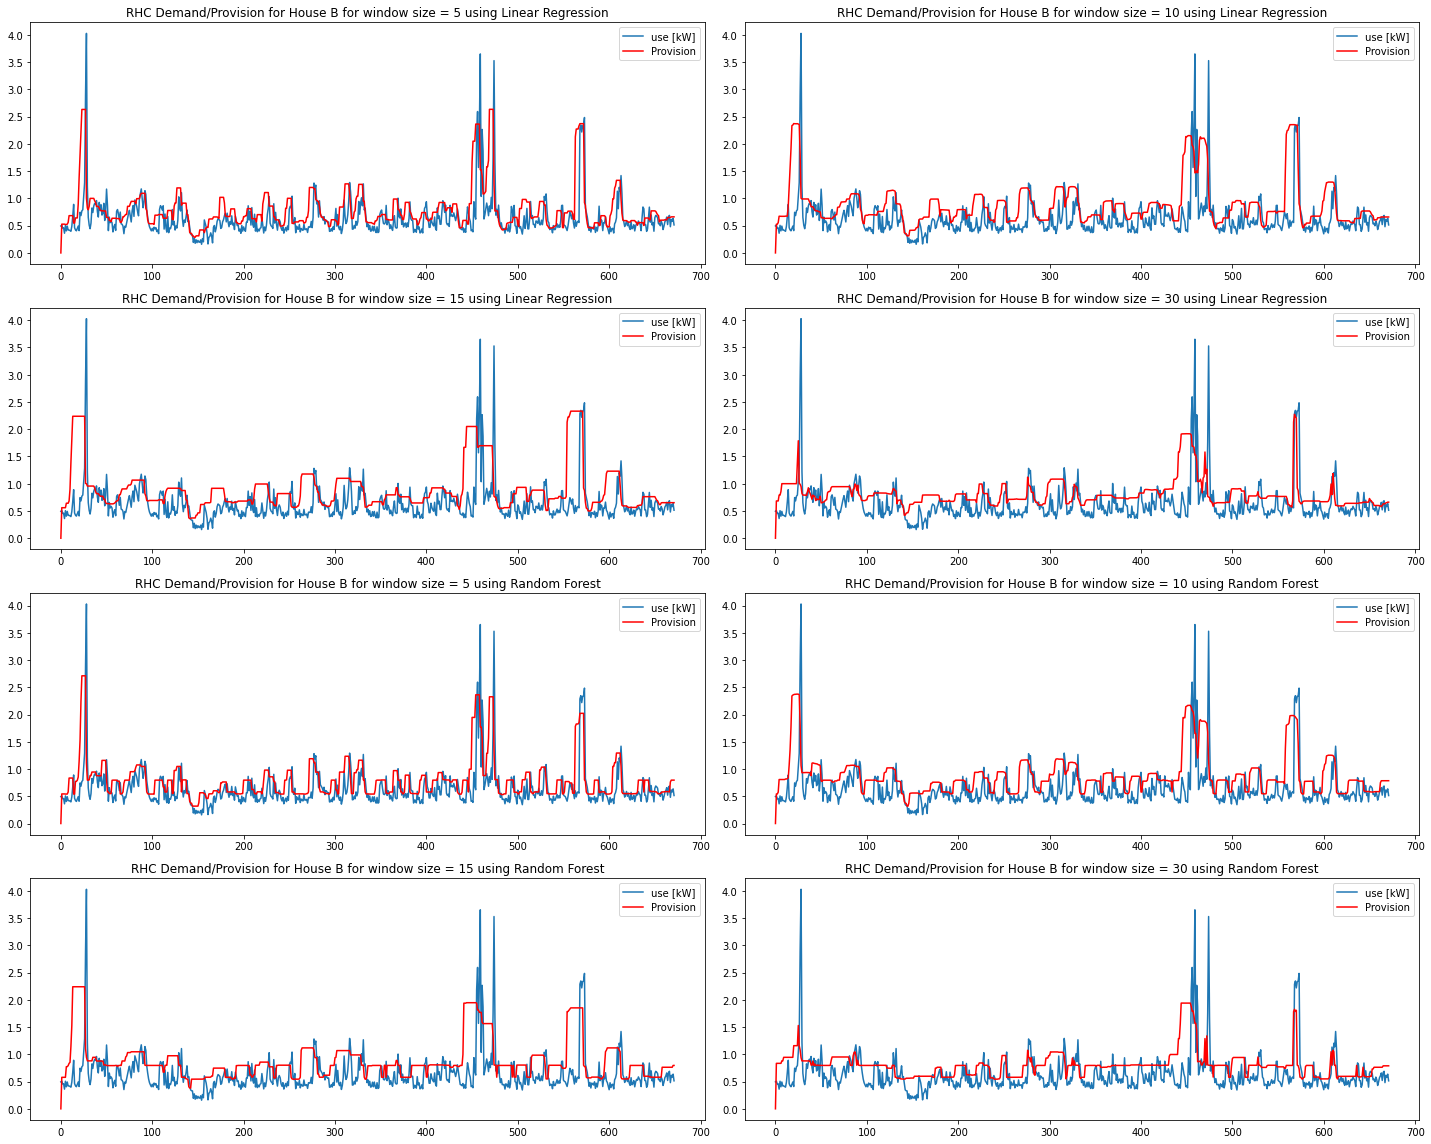

In [0]:
#RHC
rhc_cost_b=float("inf")
rhc_cost_c=float("inf")
rhc_cost_f=float("inf")

fig = plt.figure(figsize=(20,16))
axes = fig.subplots(nrows=4, ncols=2)

predwindowsize = [5,10,15,30]


row=0
col=0
y = np.asarray(homebpowerdf['use [kW]'])
y_pred = np.asarray(homeblrpreddf)
for window in predwindowsize:
  x = GetRHC(a,b,y_pred,window,price)
  cost = FindCost(y,x,price,a,b)
  if(cost<rhc_cost_b):
    rhc_cost_b = cost
  #print("Cost for window size of ",window,": ",cost)
  #plotRHC(x,homebpowerdf,'use [kW]')
  print("Optimal Cost of House B for window size = ",window," using RHC and Linear Regression predictions: ",cost)
  titlestr = "RHC Demand/Provision for House B for window size = " + str(window) + " using Linear Regression"
  MakePlot(x,homebpowerdf,'use [kW]',row,col,titlestr)
  if(col==1):
    row=row+1
    col=0
  else:
    col=1

y_pred = np.asarray(homebrfpreddf)
for window in predwindowsize:
  x = GetRHC(a,b,y_pred,window,price)
  cost = FindCost(y,x,price,a,b)
  if(cost<rhc_cost_b):
    rhc_cost_b = cost
  #print("Cost for window size of ",window,": ",cost)
  #plotRHC(x,homebpowerdf,'use [kW]')
  print("Optimal Cost of House B for window size = ",window," using RHC and Random Forest predictions: ",cost)
  titlestr = "RHC Demand/Provision for House B for window size = " + str(window) + " using Random Forest"
  MakePlot(x,homebpowerdf,'use [kW]',row,col,titlestr)
  if(col==1):
    row=row+1
    col=0
  else:
    col=1
plt.tight_layout()

Optimal Cost of House C for window size =  5  using RHC and Linear Regression predictions:  341.7212321455906
Optimal Cost of House C for window size =  10  using RHC and Linear Regression predictions:  324.5073452680736
Optimal Cost of House C for window size =  15  using RHC and Linear Regression predictions:  313.6751867221568
Optimal Cost of House C for window size =  30  using RHC and Linear Regression predictions:  305.0676264799088
Optimal Cost of House C for window size =  5  using RHC and Random Forest predictions:  346.50806717182144
Optimal Cost of House C for window size =  10  using RHC and Random Forest predictions:  318.5385837271684
Optimal Cost of House C for window size =  15  using RHC and Random Forest predictions:  298.99556376949323
Optimal Cost of House C for window size =  30  using RHC and Random Forest predictions:  297.39107224606187


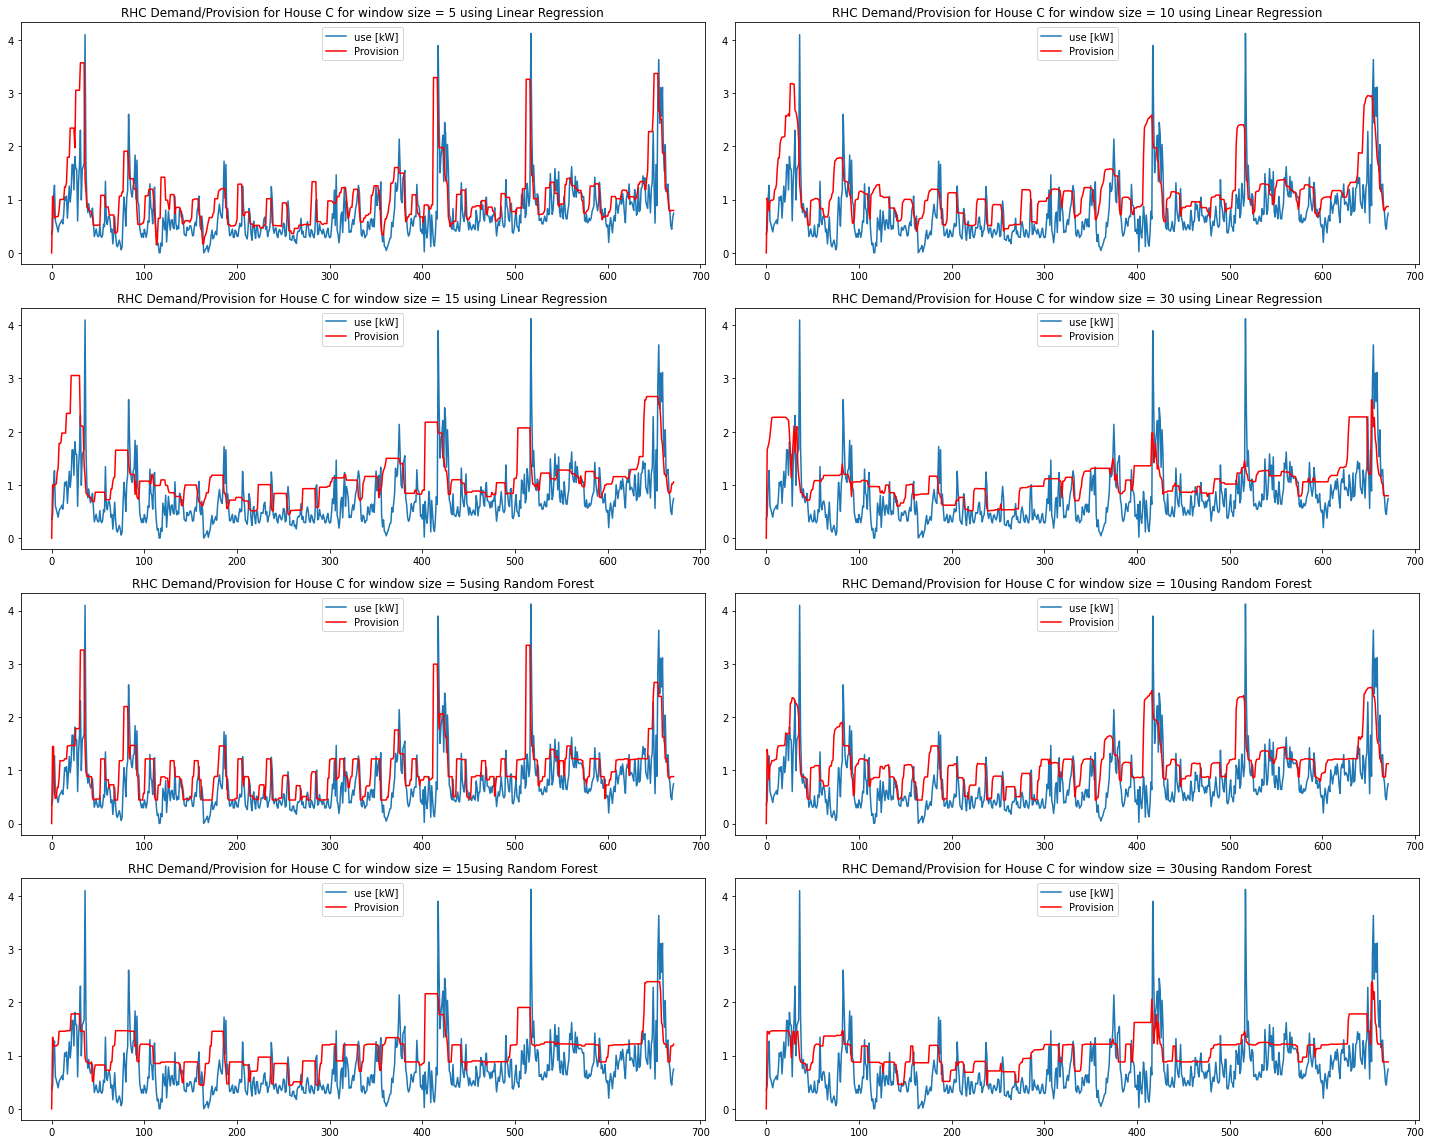

In [0]:
fig = plt.figure(figsize=(20,16))
axes = fig.subplots(nrows=4, ncols=2)

row=0
col=0
y = np.asarray(homecpowerdf['use [kW]'])
y_pred = np.asarray(homeclrpreddf)
for window in predwindowsize:
  x = GetRHC(a,b,y_pred,window,price)
  cost = FindCost(y,x,price,a,b)
  if(cost<rhc_cost_c):
    rhc_cost_c = cost
  #print("Cost for window size of ",window,": ",cost)
  #plotRHC(x,homebpowerdf,'use [kW]')
  print("Optimal Cost of House C for window size = ",window," using RHC and Linear Regression predictions: ",cost)
  titlestr = "RHC Demand/Provision for House C for window size = " + str(window) + " using Linear Regression"
  MakePlot(x,homecpowerdf,'use [kW]',row,col,titlestr)
  if(col==1):
    row=row+1
    col=0
  else:
    col=1

y_pred = np.asarray(homecrfpreddf)
for window in predwindowsize:
  x = GetRHC(a,b,y_pred,window,price)
  cost = FindCost(y,x,price,a,b)
  if(cost<rhc_cost_c):
    rhc_cost_c = cost
  #print("Cost for window size of ",window,": ",cost)
  #plotRHC(x,homebpowerdf,'use [kW]')
  print("Optimal Cost of House C for window size = ",window," using RHC and Random Forest predictions: ",cost)
  titlestr = "RHC Demand/Provision for House C for window size = " + str(window) + "using Random Forest"
  MakePlot(x,homecpowerdf,'use [kW]',row,col,titlestr)
  if(col==1):
    row=row+1
    col=0
  else:
    col=1

plt.tight_layout()

Optimal Cost of House F for window size =  5  using RHC and Linear Regression predictions:  23401.582411930234
Optimal Cost of House F for window size =  10  using RHC and Linear Regression predictions:  23179.573882357756
Optimal Cost of House F for window size =  15  using RHC and Linear Regression predictions:  22927.60516159148
Optimal Cost of House F for window size =  30  using RHC and Linear Regression predictions:  21999.434488828105
Optimal Cost of House F for window size =  5  using RHC and Random Forest predictions:  22670.93579465478
Optimal Cost of House F for window size =  10  using RHC and Random Forest predictions:  23339.201074729255
Optimal Cost of House F for window size =  15  using RHC and Random Forest predictions:  22980.530330711576
Optimal Cost of House F for window size =  30  using RHC and Random Forest predictions:  21493.746005298344


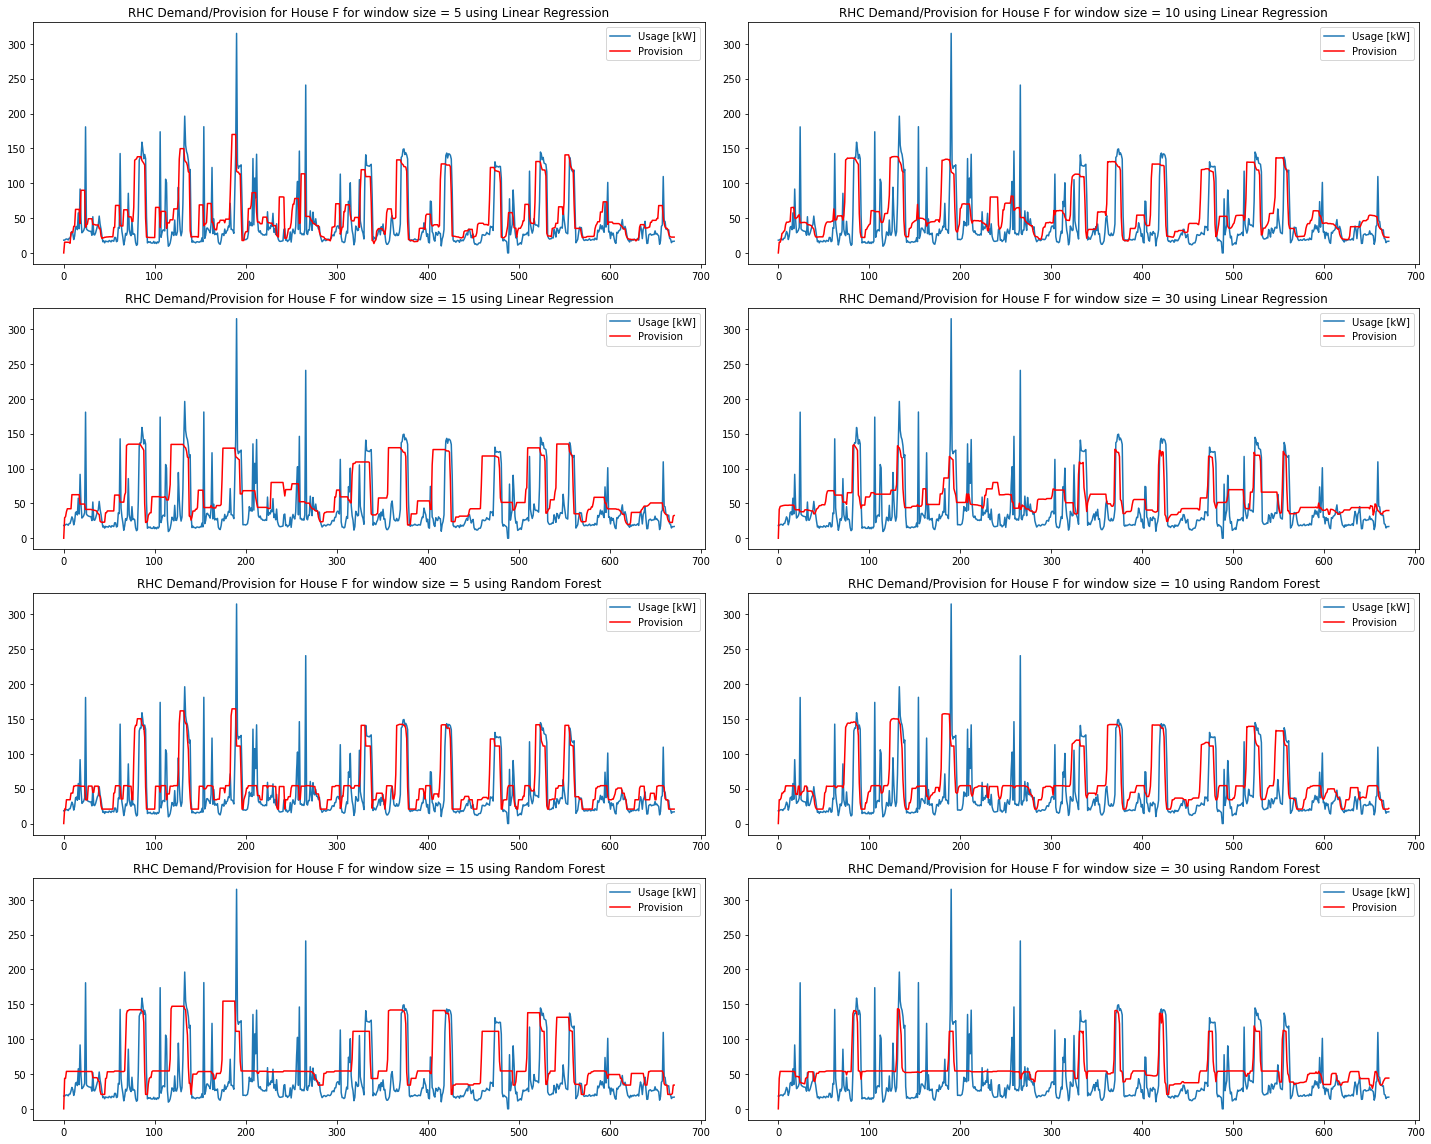

In [0]:
fig = plt.figure(figsize=(20,16))
axes = fig.subplots(nrows=4, ncols=2)

row=0
col=0
y = np.asarray(homefpowerdf['Usage [kW]'])
y_pred = np.asarray(homeflrpreddf)
for window in predwindowsize:
  x = GetRHC(a,b,y_pred,window,price)
  cost = FindCost(y,x,price,a,b)
  if(cost<rhc_cost_f):
    rhc_cost_f = cost
  #print("Cost for window size of ",window,": ",cost)
  #plotRHC(x,homebpowerdf,'use [kW]')
  print("Optimal Cost of House F for window size = ",window," using RHC and Linear Regression predictions: ",cost)
  titlestr = "RHC Demand/Provision for House F for window size = " + str(window) + " using Linear Regression"
  MakePlot(x,homefpowerdf,'Usage [kW]',row,col,titlestr)
  if(col==1):
    row=row+1
    col=0
  else:
    col=1

y_pred = np.asarray(homefrfpreddf)
for window in predwindowsize:
  x = GetRHC(a,b,y_pred,window,price)
  cost = FindCost(y,x,price,a,b)
  if(cost<rhc_cost_f):
    rhc_cost_f = cost
  #print("Cost for window size of ",window,": ",cost)
  #plotRHC(x,homebpowerdf,'use [kW]')
  print("Optimal Cost of House F for window size = ",window," using RHC and Random Forest predictions: ",cost)
  titlestr = "RHC Demand/Provision for House F for window size = " + str(window) + " using Random Forest"
  MakePlot(x,homefpowerdf,'Usage [kW]',row,col,titlestr)
  if(col==1):
    row=row+1
    col=0
  else:
    col=1

plt.tight_layout()

# Commitment Horizon Control

In [0]:
def GetCHC(a,b,y_pred,window,commitmenthorizon,price):
  x = [0]*672
  for t in range(1,672):
    if(t>=len(y_pred)):
      break
    x_optimal = cvxpy.Variable(window)
    y_window = y_pred[t:t+window]
    localcost = 0
    for i in range(len(y_window)):
        localcost += (price*x_optimal[i] + a*maximum(0,y_window[i]-x_optimal[i]) + b*abs(x_optimal[i]-x_optimal[i-1]))
    constraints = [x_optimal >= 0]
    obj = cvxpy.Minimize(localcost)
    prob = cvxpy.Problem(obj, constraints)
    prob.solve()
    for c in range(commitmenthorizon):
      index = t+c
      if index < 672:
        x[index] = x[index] + x_optimal.value[c]
  for i in range(1,672):
    x[i] = x[i]/commitmenthorizon
  return x

Optimal Cost of House B for commitment level =  3  using CHC and Linear Regression predictions:  210.72583101637574
Optimal Cost of House B for commitment level =  5  using CHC and Linear Regression predictions:  204.96335302812554
Optimal Cost of House B for commitment level =  10  using CHC and Linear Regression predictions:  198.0033475651574
Optimal Cost of House B for commitment level =  3  using CHC and Random Forest predictions:  210.51678665091833
Optimal Cost of House B for commitment level =  5  using CHC and Random Forest predictions:  202.99618135476865
Optimal Cost of House B for commitment level =  10  using CHC and Random Forest predictions:  194.91124114047562


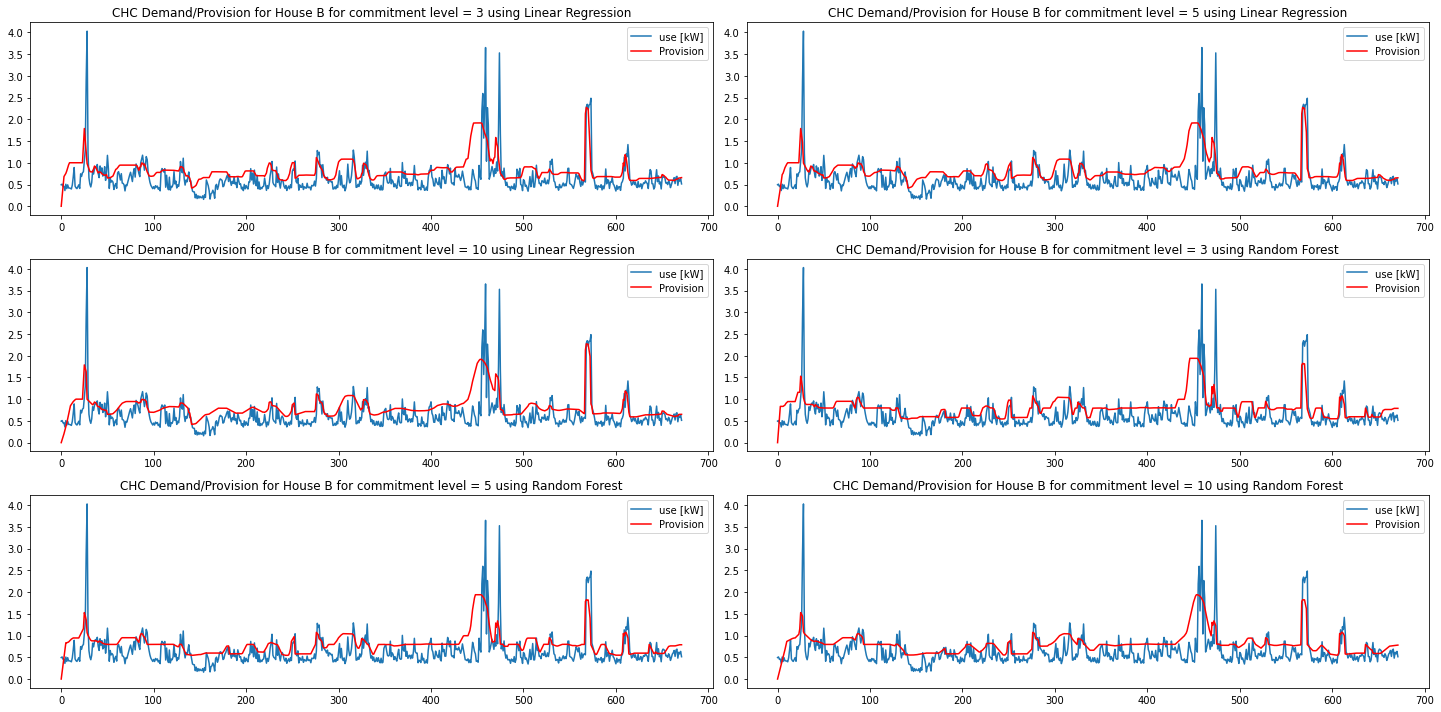

In [0]:
chc_cost_b=float("inf")
chc_cost_c=float("inf")
chc_cost_f=float("inf")

fig = plt.figure(figsize=(20,10))
axes = fig.subplots(nrows=3, ncols=2)  

commitmenthorizonarr = [3,5,10]
y = np.asarray(homebpowerdf['use [kW]'])
windowsize = 30
row=0
col=0
y_pred = np.asarray(homeblrpreddf)
for commitmenthorizon in commitmenthorizonarr:
  x = GetCHC(a,b,y_pred,windowsize,commitmenthorizon,price)
  cost = FindCost(y,x,price,a,b)
  if(cost<chc_cost_b):
    chc_cost_b = cost
  #print("Cost for commitment level of ",commitmenthorizon," and window of ",windowsize,":",cost)
  print("Optimal Cost of House B for commitment level = ",commitmenthorizon," using CHC and Linear Regression predictions: ",cost)
  titlestr = "CHC Demand/Provision for House B for commitment level = " + str(commitmenthorizon) + " using Linear Regression"
  MakePlot(x,homebpowerdf,'use [kW]',row,col,titlestr)
  if(col==1):
    row=row+1
    col=0
  else:
    col=1  

y_pred = np.asarray(homebrfpreddf)
for commitmenthorizon in commitmenthorizonarr:
  x = GetCHC(a,b,y_pred,windowsize,commitmenthorizon,price)
  cost = FindCost(y,x,price,a,b)
  if(cost<chc_cost_b):
    chc_cost_b = cost
  print("Optimal Cost of House B for commitment level = ",commitmenthorizon," using CHC and Random Forest predictions: ",cost)
  titlestr = "CHC Demand/Provision for House B for commitment level = " + str(commitmenthorizon) + " using Random Forest"
  MakePlot(x,homebpowerdf,'use [kW]',row,col,titlestr)
  if(col==1):
    row=row+1
    col=0
  else:
    col=1

plt.tight_layout()

Optimal Cost of House C for commitment level =  3  using CHC and Linear Regression predictions:  279.5480441717214
Optimal Cost of House C for commitment level =  5  using CHC and Linear Regression predictions:  269.8753861007514
Optimal Cost of House C for commitment level =  10  using CHC and Linear Regression predictions:  258.7848367281006
Optimal Cost of House C for commitment level =  3  using CHC and Random Forest predictions:  273.58184086460557
Optimal Cost of House C for commitment level =  5  using CHC and Random Forest predictions:  265.80631377348635
Optimal Cost of House C for commitment level =  10  using CHC and Random Forest predictions:  256.30009539484155


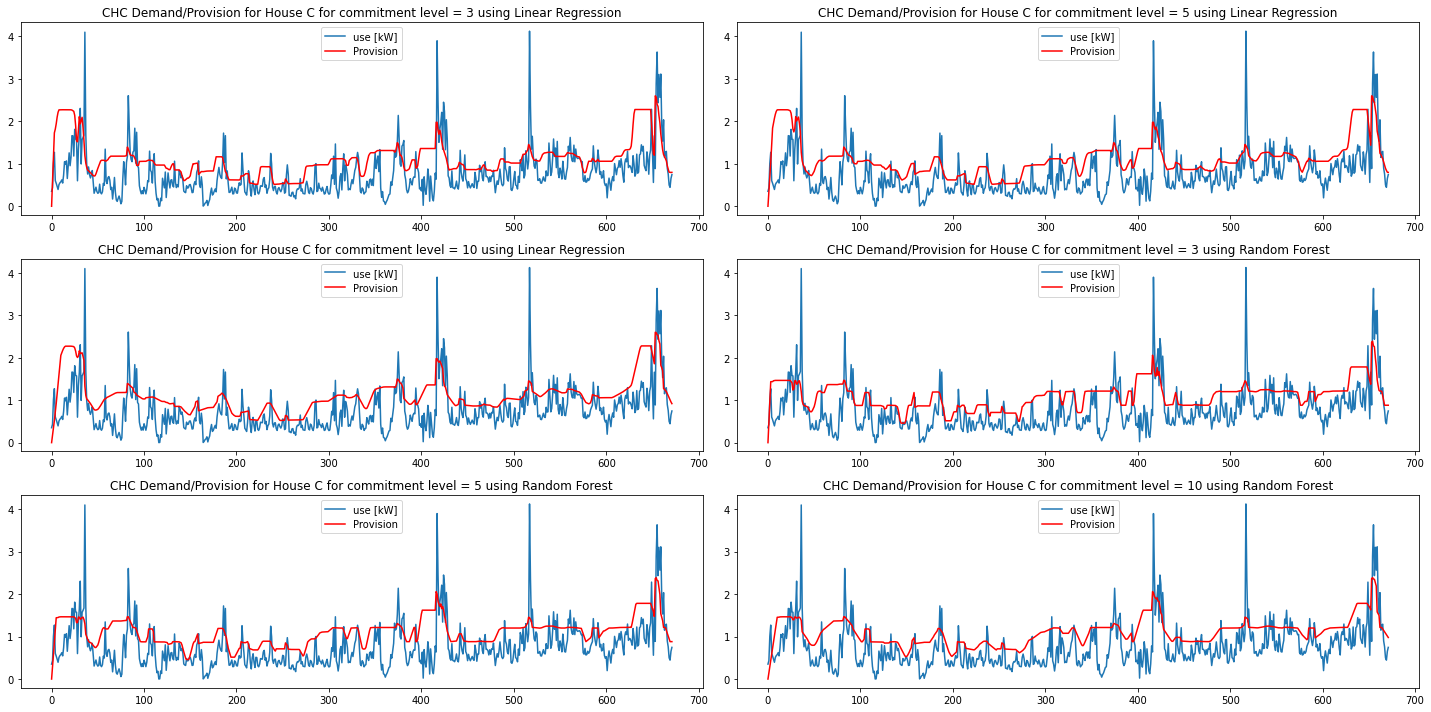

In [0]:
fig = plt.figure(figsize=(20,10))
axes = fig.subplots(nrows=3, ncols=2)  
y = np.asarray(homecpowerdf['use [kW]'])
row=0
col=0
y_pred = np.asarray(homeclrpreddf)
for commitmenthorizon in commitmenthorizonarr:
  x = GetCHC(a,b,y_pred,windowsize,commitmenthorizon,price)
  cost = FindCost(y,x,price,a,b)
  if(cost<chc_cost_c):
    chc_cost_c = cost
  #print("Cost for commitment level of ",commitmenthorizon," and window of ",windowsize,":",cost)
  print("Optimal Cost of House C for commitment level = ",commitmenthorizon," using CHC and Linear Regression predictions: ",cost)
  titlestr = "CHC Demand/Provision for House C for commitment level = " + str(commitmenthorizon) + " using Linear Regression"
  MakePlot(x,homecpowerdf,'use [kW]',row,col,titlestr)
  if(col==1):
    row=row+1
    col=0
  else:
    col=1  

y_pred = np.asarray(homecrfpreddf)
for commitmenthorizon in commitmenthorizonarr:
  x = GetCHC(a,b,y_pred,windowsize,commitmenthorizon,price)
  cost = FindCost(y,x,price,a,b)
  if(cost<chc_cost_c):
    chc_cost_c = cost
  print("Optimal Cost of House C for commitment level = ",commitmenthorizon," using CHC and Random Forest predictions: ",cost)
  titlestr = "CHC Demand/Provision for House C for commitment level = " + str(commitmenthorizon) + " using Random Forest"
  MakePlot(x,homecpowerdf,'use [kW]',row,col,titlestr)
  if(col==1):
    row=row+1
    col=0
  else:
    col=1

plt.tight_layout()

Optimal Cost of House F for commitment level =  3  using CHC and Linear Regression predictions:  20387.007474493894
Optimal Cost of House F for commitment level =  5  using CHC and Linear Regression predictions:  19709.725217934774
Optimal Cost of House F for commitment level =  10  using CHC and Linear Regression predictions:  18999.192479517864
Optimal Cost of House F for commitment level =  3  using CHC and Random Forest predictions:  20011.39057484112
Optimal Cost of House F for commitment level =  5  using CHC and Random Forest predictions:  19393.845612803965
Optimal Cost of House F for commitment level =  10  using CHC and Random Forest predictions:  18831.175837123163


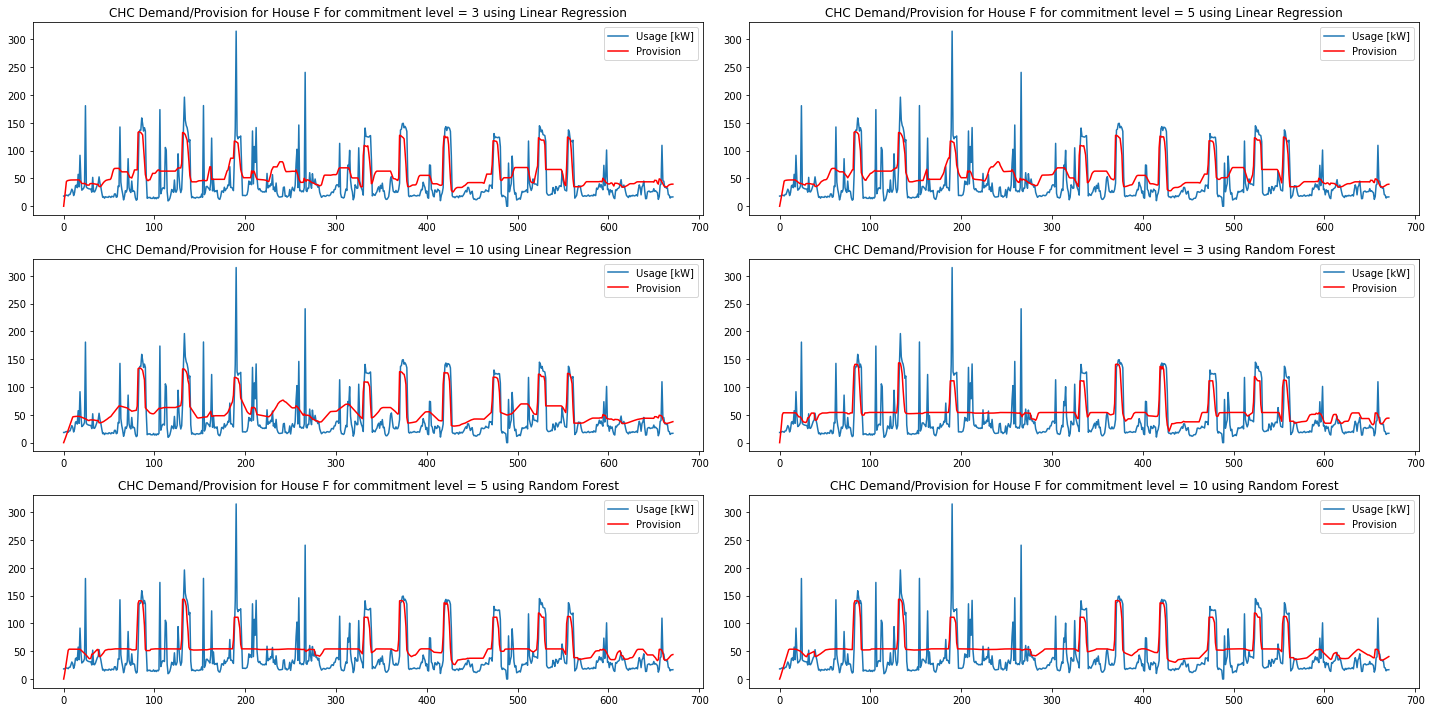

In [0]:
fig = plt.figure(figsize=(20,10))
axes = fig.subplots(nrows=3, ncols=2)  
y = np.asarray(homefpowerdf['Usage [kW]'])
row=0
col=0
y_pred = np.asarray(homeflrpreddf)
for commitmenthorizon in commitmenthorizonarr:
  x = GetCHC(a,b,y_pred,windowsize,commitmenthorizon,price)
  cost = FindCost(y,x,price,a,b)
  if(cost<chc_cost_f):
    chc_cost_f = cost
  #print("Cost for commitment level of ",commitmenthorizon," and window of ",windowsize,":",cost)
  print("Optimal Cost of House F for commitment level = ",commitmenthorizon," using CHC and Linear Regression predictions: ",cost)
  titlestr = "CHC Demand/Provision for House F for commitment level = " + str(commitmenthorizon) + " using Linear Regression"
  MakePlot(x,homefpowerdf,'Usage [kW]',row,col,titlestr)
  if(col==1):
    row=row+1
    col=0
  else:
    col=1  

y_pred = np.asarray(homefrfpreddf)
for commitmenthorizon in commitmenthorizonarr:
  x = GetCHC(a,b,y_pred,windowsize,commitmenthorizon,price)
  cost = FindCost(y,x,price,a,b)
  if(cost<chc_cost_f):
    chc_cost_f = cost
  print("Optimal Cost of House F for commitment level = ",commitmenthorizon," using CHC and Random Forest predictions: ",cost)
  titlestr = "CHC Demand/Provision for House F for commitment level = " + str(commitmenthorizon) + " using Random Forest"
  MakePlot(x,homefpowerdf,'Usage [kW]',row,col,titlestr)
  if(col==1):
    row=row+1
    col=0
  else:
    col=1

plt.tight_layout()
  

# Comparison of Algorithm costs

In [0]:
#Regret
rhcstaticregret = []
ogdstaticregret =[]
chcstaticregret = []
ogddynamicregret = []
rhcdynamicregret = []
chcdynamicregret = []

rhcstaticregret.append(rhc_cost_b - offline_static_cost_b)
rhcstaticregret.append(rhc_cost_c - offline_static_cost_c)
rhcstaticregret.append(rhc_cost_f - offline_static_cost_f)
chcstaticregret.append(chc_cost_b - offline_static_cost_b)
chcstaticregret.append(chc_cost_c - offline_static_cost_c)
chcstaticregret.append(chc_cost_f - offline_static_cost_f)
ogdstaticregret.append(ogd_cost_b - offline_static_cost_b)
ogdstaticregret.append(ogd_cost_c - offline_static_cost_c)
ogdstaticregret.append(ogd_cost_f - offline_static_cost_f)

ogddynamicregret.append(ogd_cost_b - offline_dynamic_cost_b)
ogddynamicregret.append(ogd_cost_c - offline_dynamic_cost_c)
ogddynamicregret.append(ogd_cost_f - offline_dynamic_cost_f)
rhcdynamicregret.append(rhc_cost_b - offline_dynamic_cost_b)
rhcdynamicregret.append(rhc_cost_c - offline_dynamic_cost_c)
rhcdynamicregret.append(rhc_cost_f - offline_dynamic_cost_f)
chcdynamicregret.append(chc_cost_b - offline_dynamic_cost_b)
chcdynamicregret.append(chc_cost_c - offline_dynamic_cost_c)
chcdynamicregret.append(chc_cost_f - offline_dynamic_cost_f)

house = ["B","C","F"]

finalcomparison = pd.DataFrame({
    'House' : house,
    'OGD Static Regret': ogdstaticregret,
    'OGD Dynamic Regret': ogddynamicregret,
    'RHC Static Regret': rhcstaticregret,
    'RHC Dynamic Regret': rhcdynamicregret,
    'CHC Static Regret': chcstaticregret,
    'CHC Dynamic Regret': chcdynamicregret,
})
display(finalcomparison)

,House,OGD Static Regret,OGD Dynamic Regret,RHC Static Regret,RHC Dynamic Regret,CHC Static Regret,CHC Dynamic Regret
0,B,30.664192,63.217623,33.009167,65.562598,1.886614,34.440045
1,C,36.706255,84.187006,40.110686,87.591438,-0.980290,46.500461
2,F,4678.523396,9088.128676,2339.587068,6749.192348,-322.983100,4086.622180


# Impact of varying 'a' and 'b'

Optimal Cost of House B for a =  1  using CHC and Random Forest predictions: 162.7403848271199
Optimal Cost of House B for a =  2  using CHC and Random Forest predictions: 194.91124114047562
Optimal Cost of House B for a =  5  using CHC and Random Forest predictions: 270.3659201989275
Optimal Cost of House B for a =  9  using CHC and Random Forest predictions: 354.92521239253216
Optimal Cost of House B for a =  12  using CHC and Random Forest predictions: 418.3220322800158
Optimal Cost of House B for a =  15  using CHC and Random Forest predictions: 481.64426785602217


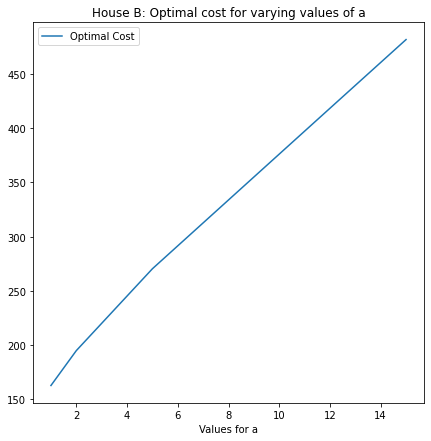

In [0]:
#Varying a and b
#Optimal Cost of House B for commitment level =  10  using CHC and Random Forest predictions:  194.91124114047562

resultcostarray=[]
a_array = [1, 2, 5, 9, 12, 15]
b = 2   
y = np.asarray(homebpowerdf['use [kW]'])
y_pred = np.asarray(homebrfpreddf)
commitmenthorizon = 10
windowsize = 30
for a_vary in a_array:
  x = GetCHC(a_vary,b,y_pred,windowsize,commitmenthorizon,price)
  cost = FindCost(y,x,price,a_vary,b)
  print("Optimal Cost of House B for a = ",a_vary," using CHC and Random Forest predictions:",cost)
  resultcostarray.append(cost)
varyadf = pd.DataFrame({
  'Values for a': a_array,
  'Optimal Cost': resultcostarray,
})
varyadf.plot(x='Values for a', y='Optimal Cost',figsize=(7,7),title="House B: Optimal cost for varying values of a")

Optimal Cost of House B for b =  1  using CHC and Random Forest predictions: 190.1779470542618
Optimal Cost of House B for b =  2  using CHC and Random Forest predictions: 194.91124114047562
Optimal Cost of House B for b =  5  using CHC and Random Forest predictions: 226.25928590352282
Optimal Cost of House B for b =  9  using CHC and Random Forest predictions: 267.26654031846635
Optimal Cost of House B for b =  12  using CHC and Random Forest predictions: 298.1248933704585
Optimal Cost of House B for b =  15  using CHC and Random Forest predictions: 328.98746105013583


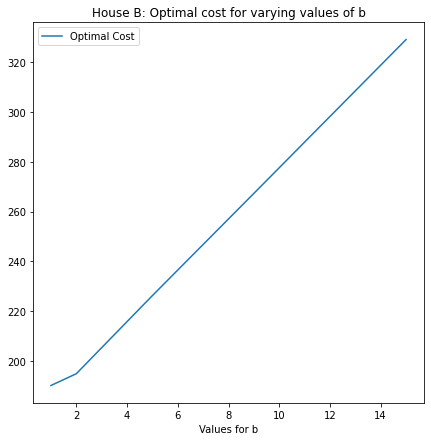

In [0]:
#Varying a and b
#Optimal Cost of House B for commitment level =  10  using CHC and Random Forest predictions:  194.91124114047562

resultcostarray=[]
b_array = [1, 2, 5, 9, 12, 15]
a = 2   
y = np.asarray(homebpowerdf['use [kW]'])
y_pred = np.asarray(homebrfpreddf)
commitmenthorizon = 10
windowsize = 30
for b_vary in b_array:
  x = GetCHC(a,b_vary,y_pred,windowsize,commitmenthorizon,price)
  cost = FindCost(y,x,price,a,b_vary)
  print("Optimal Cost of House B for b = ",b_vary," using CHC and Random Forest predictions:",cost)
  resultcostarray.append(cost)
varybdf = pd.DataFrame({
  'Values for b': b_array,
  'Optimal Cost': resultcostarray,
})
varybdf.plot(x='Values for b', y='Optimal Cost',figsize=(7,7),title="House B: Optimal cost for varying values of b")

Optimal Cost of House C for a =  1  using CHC and Random Forest predictions: 211.89925786624698
Optimal Cost of House C for a =  2  using CHC and Random Forest predictions: 256.30009539484155
Optimal Cost of House C for a =  5  using CHC and Random Forest predictions: 384.2596858560391
Optimal Cost of House C for a =  9  using CHC and Random Forest predictions: 511.91171531857543
Optimal Cost of House C for a =  12  using CHC and Random Forest predictions: 607.6650902757048
Optimal Cost of House C for a =  15  using CHC and Random Forest predictions: 703.394301160925


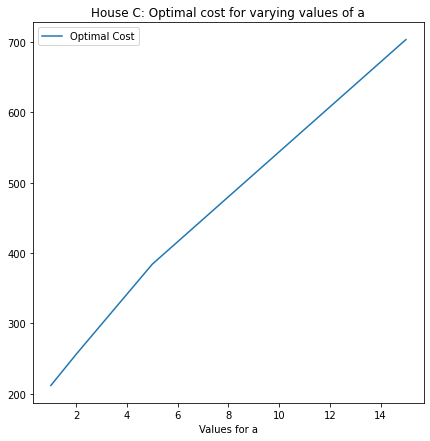

In [0]:
#Optimal Cost of House C for commitment level =  10  using CHC and Random Forest predictions:  256.30009539484155
resultcostarray=[]
a_array = [1, 2, 5, 9, 12, 15]
b = 2   
y = np.asarray(homecpowerdf['use [kW]'])
y_pred = np.asarray(homecrfpreddf)
commitmenthorizon = 10
windowsize = 30
for a_vary in a_array:
  x = GetCHC(a_vary,b,y_pred,windowsize,commitmenthorizon,price)
  cost = FindCost(y,x,price,a_vary,b)
  print("Optimal Cost of House C for a = ",a_vary," using CHC and Random Forest predictions:",cost)
  resultcostarray.append(cost)
varyadf = pd.DataFrame({
  'Values for a': a_array,
  'Optimal Cost': resultcostarray,
})
varyadf.plot(x='Values for a', y='Optimal Cost',figsize=(7,7),title="House C: Optimal cost for varying values of a")

Optimal Cost of House C for b =  1  using CHC and Random Forest predictions: 247.53538795985992
Optimal Cost of House C for b =  2  using CHC and Random Forest predictions: 256.30009539484155
Optimal Cost of House C for b =  5  using CHC and Random Forest predictions: 283.9514731477341
Optimal Cost of House C for b =  9  using CHC and Random Forest predictions: 329.74546647961034
Optimal Cost of House C for b =  12  using CHC and Random Forest predictions: 364.41081418217846
Optimal Cost of House C for b =  15  using CHC and Random Forest predictions: 399.06518298847647


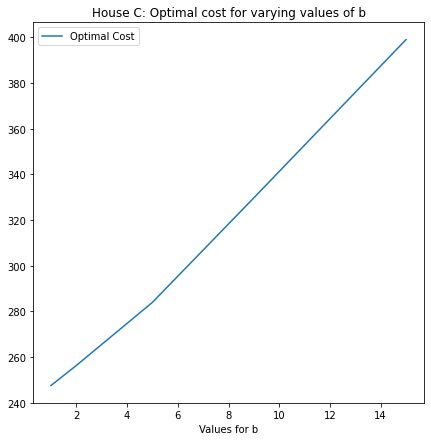

In [0]:
#Varying a and b
#Optimal Cost of House C for commitment level =  10  using CHC and Random Forest predictions:  194.91124114047562

resultcostarray=[]
b_array = [1, 2, 5, 9, 12, 15]
a = 2   
y = np.asarray(homecpowerdf['use [kW]'])
y_pred = np.asarray(homecrfpreddf)
commitmenthorizon = 10
windowsize = 30
for b_vary in b_array:
  x = GetCHC(a,b_vary,y_pred,windowsize,commitmenthorizon,price)
  cost = FindCost(y,x,price,a,b_vary)
  print("Optimal Cost of House C for b = ",b_vary," using CHC and Random Forest predictions:",cost)
  resultcostarray.append(cost)
varybdf = pd.DataFrame({
  'Values for b': b_array,
  'Optimal Cost': resultcostarray,
})
varybdf.plot(x='Values for b', y='Optimal Cost',figsize=(7,7),title="House C: Optimal cost for varying values of b")

Optimal Cost of House F for a =  1  using CHC and Random Forest predictions: 15230.588927250574
Optimal Cost of House F for a =  2  using CHC and Random Forest predictions: 18831.175837123163
Optimal Cost of House F for a =  10  using CHC and Random Forest predictions: 48333.86234607315
Optimal Cost of House F for a =  15  using CHC and Random Forest predictions: 66566.18206277693


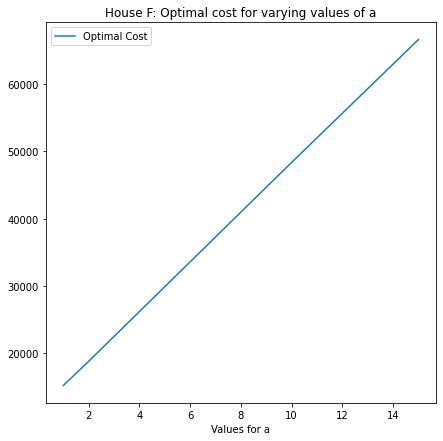

In [0]:
#Optimal Cost of House F for commitment level =  10  using CHC and Random Forest predictions:  18831.175837123163
resultcostarray=[]
a_array = [1, 2, 10, 15]
b = 2   
y = np.asarray(homefpowerdf['Usage [kW]'])
y_pred = np.asarray(homefrfpreddf)
commitmenthorizon = 10
windowsize = 30
for a_vary in a_array:
  x = GetCHC(a_vary,b,y_pred,windowsize,commitmenthorizon,price)
  cost = FindCost(y,x,price,a_vary,b)
  print("Optimal Cost of House F for a = ",a_vary," using CHC and Random Forest predictions:",cost)
  resultcostarray.append(cost)
varyadf = pd.DataFrame({
  'Values for a': a_array,
  'Optimal Cost': resultcostarray,
})
varyadf.plot(x='Values for a', y='Optimal Cost',figsize=(7,7),title="House F: Optimal cost for varying values of a")

Optimal Cost of House F for b =  1  using CHC and Random Forest predictions: 17502.100988136586
Optimal Cost of House F for b =  2  using CHC and Random Forest predictions: 18831.175837123163
Optimal Cost of House F for b =  10  using CHC and Random Forest predictions: 30045.1136919035
Optimal Cost of House F for b =  15  using CHC and Random Forest predictions: 36784.63618981476


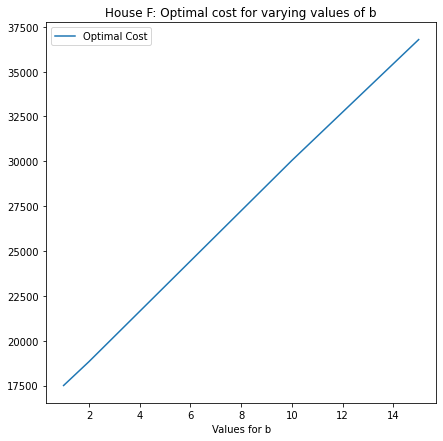

In [0]:
resultcostarray=[]
b_array = [1, 2, 10, 15]
a = 2   
y = np.asarray(homefpowerdf['Usage [kW]'])
y_pred = np.asarray(homefrfpreddf)
commitmenthorizon = 10
windowsize = 30
for b_vary in b_array:
  x = GetCHC(a,b_vary,y_pred,windowsize,commitmenthorizon,price)
  cost = FindCost(y,x,price,a,b_vary)
  print("Optimal Cost of House F for b = ",b_vary," using CHC and Random Forest predictions:",cost)
  resultcostarray.append(cost)
varybdf = pd.DataFrame({
  'Values for b': b_array,
  'Optimal Cost': resultcostarray,
})
varybdf.plot(x='Values for b', y='Optimal Cost',figsize=(7,7),title="House F: Optimal cost for varying values of b")

# Deterministic Algorithm Selection

Total optimal cost: 212.62251266510862
Total optimal cost: 250.37812278241987
Total optimal cost: 18696.301654513296


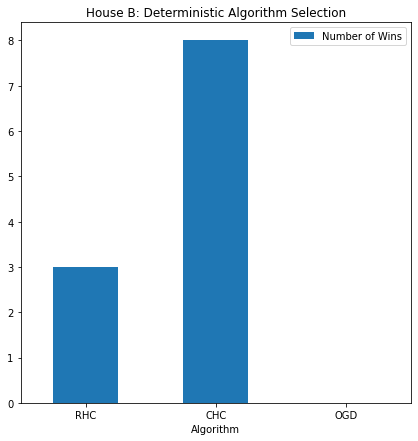

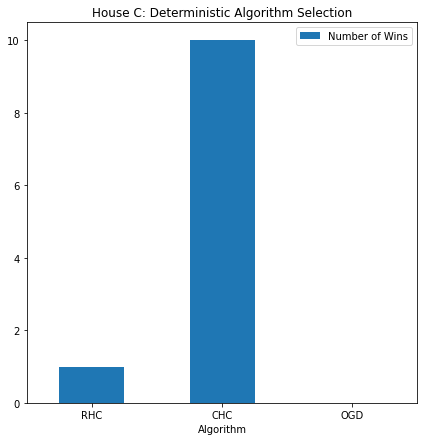

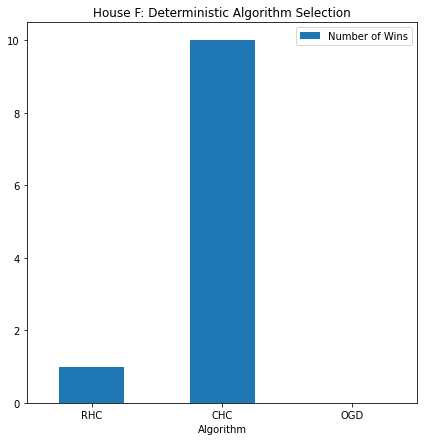

In [0]:
#deterministic algorithm selection

def deterministicselection(df,dfpred,param,house):
  price = 0.2 # 0.4$/kwH -> 0.4/2 $ / kW 30 min -> 0.2$
  a=2 #4$/kwH -> 2$/kw 30 min
  b=2 #4$/kwH -> 2$/kw 30 min
  delta = 56
  i=0
  y = np.asarray(df[param])
  y_pred = np.asarray(dfpred)
  window=10
  commitmenthorizon = 10
  win_rhc =0
  win_chc = 0
  win_ogd = 0
  totalcost = 0
  while i+delta<672:
    y_delta = y[i:i+delta]
    y_pred_delta = y_pred[i:i+delta]
    x_rhc = GetRHC(a,b,y_pred_delta,window,price)
    cost_rhc = FindCost(y_delta,x_rhc,price,a,b)
    currentmin = cost_rhc
    currentminalgo = 0 #0,1,2 rhc chc ogd
    x_chc = GetCHC(a,b,y_pred_delta,window,commitmenthorizon,price)
    cost_chc = FindCost(y_delta,x_chc,price,a,b)
    if(cost_chc<currentmin):
      currentmin = cost_chc
      currentminalgo = 1 #0,1,2 rhc chc ogd   
    stepsize=[] 
    for j in range (1,len(y_delta)):
      stepsize.append(1/j)
    x_ogd = OnlineGradientDescent(y_delta,stepsize,price,a,b)
    cost_ogd = FindCost(y_delta,x_ogd,price,a,b)
    if(cost_ogd<currentmin):
      currentmin = cost_ogd
      currentminalgo = 2 #0,1,2 rhc chc ogd   
    if(currentminalgo==0):
      win_rhc+=1
    elif(currentminalgo==1):
      win_chc+=1  
    else:
      win_ogd+=1  
    totalcost+=currentmin
    i=i+delta
    #print("Finished ",i,"th iteration")
  print("Total optimal cost:",totalcost)
  df = pd.DataFrame({'Algorithm':['RHC', 'CHC', 'OGD'], 'Number of Wins':[win_rhc, win_chc, win_ogd]})
  titleplot = "House "+house+": Deterministic Algorithm Selection"
  ax = df.plot.bar(x='Algorithm', y='Number of Wins', rot=0,figsize=(7,7),title=titleplot)

deterministicselection(homebpowerdf,homebrfpreddf,'use [kW]',"B")
deterministicselection(homecpowerdf,homecrfpreddf,'use [kW]',"C")
deterministicselection(homefpowerdf,homefrfpreddf,'Usage [kW]',"F")

# Randomized Algorithm Selection

Total optimal cost: 213.25163089512375
Total optimal cost: 278.5106303023459
Total optimal cost: 20182.84837232718


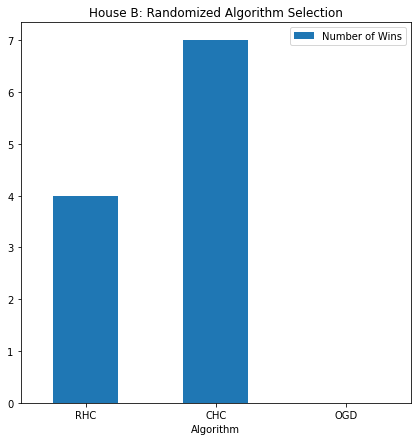

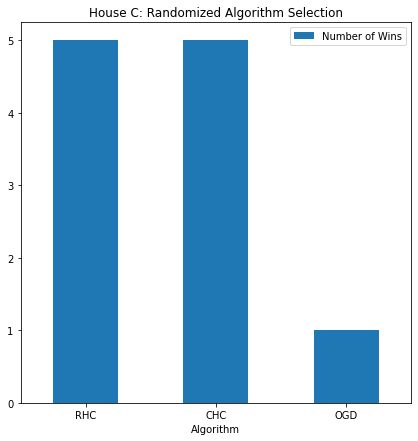

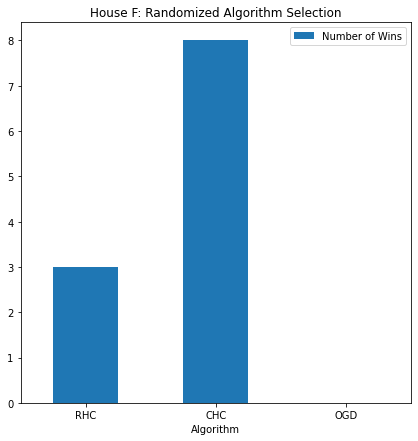

In [0]:
#randomized algorithm selection

def randomizedselection(df,dfpred,param,house):
  price = 0.2 # 0.4$/kwH -> 0.4/2 $ / kW 30 min -> 0.2$
  a=2 #4$/kwH -> 2$/kw 30 min
  b=2 #4$/kwH -> 2$/kw 30 min
  delta = 56
  i=0
  y = np.asarray(df[param])
  y_pred = np.asarray(dfpred)
  window=10
  commitmenthorizon = 10
  win_rhc =0
  win_chc = 0
  win_ogd = 0
  totalcost = 0
  while i+delta<672:
    y_delta = y[i:i+delta]
    y_pred_delta = y_pred[i:i+delta]
    listsort=[]   
    x_rhc = GetRHC(a,b,y_pred_delta,window,price)
    cost_rhc = FindCost(y_delta,x_rhc,price,a,b)
    listsort.append(cost_rhc)
    x_chc = GetCHC(a,b,y_pred_delta,window,commitmenthorizon,price)
    cost_chc = FindCost(y_delta,x_chc,price,a,b)
    listsort.append(cost_chc)
    stepsize=[] 
    for j in range (1,len(y_delta)):
      stepsize.append(1/j)
    x_ogd = OnlineGradientDescent(y_delta,stepsize,price,a,b)
    cost_ogd = FindCost(y_delta,x_ogd,price,a,b)
    listsort.append(cost_ogd)
    listsort.sort(reverse=True)
    #print(cost_ogd,",",cost_rhc,",",cost_chc,",",listsort)
    one = 0.1
    two = 0.3
    three = 0.6
    if(cost_ogd==listsort[0]):
      p_ogd = one
    elif(cost_ogd==listsort[1]):
      p_ogd = two
    else:
      p_ogd = three   
    if(cost_rhc==listsort[0]):
      p_rhc = one
    elif(cost_rhc==listsort[1]):
      p_rhc = two
    else:
      p_rhc = three  
    if(cost_chc==listsort[0]):
      p_chc = one
    elif(cost_chc==listsort[1]):
      p_chc = two
    else:
      p_chc = three           
    #print(p_rhc,",",p_chc,",",p_ogd)
    x=np.random.choice(
      ['RHC', 'CHC', 'OGD'], 
      p=[p_rhc, p_chc, p_ogd]
    )
    currentcost=0
    if(x=="RHC"):
      win_rhc+=1
      currentcost = cost_rhc
    elif(x=="CHC"):
      win_chc+=1  
      currentcost = cost_chc
    else:
      win_ogd+=1  
      currentcost = cost_ogd
    totalcost+= currentcost
    i=i+delta
    #print("Finished ",i,"th iteration")
  print("Total optimal cost:",totalcost)
  #print("Number of wins:")
  df = pd.DataFrame({'Algorithm':['RHC', 'CHC', 'OGD'], 'Number of Wins':[win_rhc, win_chc, win_ogd]})
  titleplot = "House "+house+": Randomized Algorithm Selection"
  ax = df.plot.bar(x='Algorithm', y='Number of Wins', rot=0,figsize=(7,7),title=titleplot)

randomizedselection(homebpowerdf,homebrfpreddf,'use [kW]',"B")
randomizedselection(homecpowerdf,homecrfpreddf,'use [kW]',"C")
randomizedselection(homefpowerdf,homefrfpreddf,'Usage [kW]',"F")